# Exercice 3   

**Question 1**: Modelisation du problème de plus court chemin comme problème du flot de coût minimum

$G=(V,E)$, source: $s \in V$, puit: $t \in V$

$a(u,v)$: cout pour passer de u à v, $f(u,v)=1$ si $(u,v) \in $ {plus court chemin} 

Programme linéaire:
\begin{align*}
\min&\sum_{(u,v)\in E} a(u,v)f(u,v)&\\
s.c.& \sum_{(u,v)\in E}f(u,v) = \sum_{(v,w)\in E}f(v,w) \quad \forall v \in V \setminus \{s, t\}& \text{, contrainte de conservation du flux}\\
    & \sum_{s,v \in E} f(s,v) >= 1 &\text{ , contrainte de flux sortant de la source}\\
    &f(u,v)\in (0,1) \quad \forall (u,v) \in E&
\end{align*}

**Question 2:** Application aux exemples

In [41]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

In [42]:
couts_i1 = [{
        ('a','b'): 4,
        ('a','c'): 5,
        ('b','c'): 2,
        ('b','d'): 1,
        ('b','e'): 2,
        ('b','f'): 7,
        ('c','d'): 5,
        ('c','e'): 2,
        ('d','f'): 3,
        ('e','f'): 5
    },
    {
        ('a','b'): 3,
        ('a','c'): 1,
        ('b','c'): 1,
        ('b','d'): 4,
        ('b','e'): 2,
        ('b','f'): 5,
        ('c','d'): 1,
        ('c','e'): 7,
        ('d','f'): 2,
        ('e','f'): 2
    }
]

couts_i2 = [
    {
        ('a','b'): 5,
        ('a','c'): 10,
        ('a','d'): 2,
        ('b','c'): 4,
        ('b','d'): 1,
        ('b','e'): 4,
        ('c','e'): 3,
        ('c','f'): 1,
        ('d','c'): 1,
        ('d','f'): 3,
        ('e','g'): 1,
        ('f','g'): 1
    },
    {
        ('a','b'): 3,
        ('a','c'): 4,
        ('a','d'): 6,
        ('b','c'): 2,
        ('b','d'): 3,
        ('b','e'): 6,
        ('c','e'): 1,
        ('c','f'): 2,
        ('d','c'): 4,
        ('d','f'): 5,
        ('e','g'): 1,
        ('f','g'): 1
    }
]



In [43]:
def minFlow(couts):
    # trouver noeuds
    noeuds = set()
    for arc in couts:
        noeuds.update(arc)
    noeuds = list(noeuds)

    source = min(noeuds)
    puits = max(noeuds)

    model = Model()
    model.params.LogToConsole = False

    f = model.addVars(couts.keys(), vtype = GRB.BINARY, name='f')
    model.setObjective(quicksum([f[i,j] * cout for (i,j),cout in couts.items()]), GRB.MINIMIZE)

    # contrainte de conservation du flux
    for v in noeuds:
        if v == source or v == puits:
            continue
        flux_entrant = quicksum([f[i,v] for i,j in couts if j == v])
        flux_sortant = quicksum([f[v,j] for i,j in couts if i == v])
        model.addConstr(flux_entrant == flux_sortant)

    #for arc, cout in couts.items():
        #model.addConstr(f[arc] <= cout )    # contrainte de capacité
        #model.addConstr(f[arc] >= 0)        # contrainte de non-negativité


    model.addConstr(quicksum([f[source, j] for i,j in couts if i == source]) >= 1)


    model.optimize()
    objets_selectiones = [(i,j) for i,j in couts if f[i,j].X > 0.5]
    print('Chemin: ', objets_selectiones,', coût: ', int(model.ObjVal))

In [44]:
for i, couts_instances in enumerate([couts_i1, couts_i2]):
    print(f"Plus court chemin de l'instance {i} : ")
    for j,couts in enumerate(couts_instances):
        print(f"Scénario {j}:")
        minFlow(couts)


Plus court chemin de l'instance 0 : 
Scénario 0:
Chemin:  [('a', 'b'), ('b', 'd'), ('d', 'f')] , coût:  8
Scénario 1:
Chemin:  [('a', 'c'), ('c', 'd'), ('d', 'f')] , coût:  4
Plus court chemin de l'instance 1 : 
Scénario 0:
Chemin:  [('a', 'd'), ('c', 'f'), ('d', 'c'), ('f', 'g')] , coût:  5
Scénario 1:
Chemin:  [('a', 'c'), ('c', 'e'), ('e', 'g')] , coût:  6


**Question 3:**

## maxmin
Programme linéaire pour $n$ scénarios:
\begin{align*}
\min\quad   & t&&\\
s.c.\quad   &t\ge\sum_{(u,v)\in E} a_i(u,v)f(u,v)&i\in\{1,\ldots,n\}\\
            & \sum_{(u,v)\in E}f(u,v) = \sum_{(v,w)\in E}f(v,w) \quad \forall v \in V \setminus \{s, t\}& \text{, contrainte de conservation du flux}\\
            & \sum_{s,v \in E} f(s,v) >= 1 &\text{ , contrainte de flux sortant de la source}&\\
            &f(u,v)\in \{0,1\} \quad \forall (u,v) \in E&
\end{align*}

In [45]:
def minFlowMaxMin(valeurs_scenarios):
    # trouver noeuds
    # on suppose que tous les scénarios ont les mêmes arcs


    noeuds = set()
    for arc in valeurs_scenarios[0]:
        noeuds.update(arc)
    noeuds = list(noeuds)

    source = min(noeuds)
    puits = max(noeuds)

    model = Model()
    model.params.LogToConsole = False

    f = model.addVars(valeurs_scenarios[0].keys(), vtype = GRB.BINARY, name='f')
    t = model.addVar(vtype = GRB.INTEGER)


    model.setObjective(t, GRB.MINIMIZE)
   
    # contrainte de t
    for couts in valeurs_scenarios:
        model.addConstr(t >= quicksum([f[i,j] * cout for (i,j),cout in couts.items()]))

    # contrainte de conservation du flux
    for v in noeuds:
        if v == source or v == puits:
            continue
        flux_entrant = quicksum([f[i,v] for i,j in couts if j == v])
        flux_sortant = quicksum([f[v,j] for i,j in couts if i == v])
        model.addConstr(flux_entrant == flux_sortant)

    #for arc, cout in couts.items():
        #model.addConstr(f[arc] <= cout )    # contrainte de capacité
        #model.addConstr(f[arc] >= 0)        # contrainte de non-negativité


    model.addConstr(quicksum([f[source, j] for i,j in couts if i == source]) >= 1)


    model.optimize()

    objets_selectiones = [(i,j) for i,j in couts if f[i,j].X > 0.5]

    vecteur_z = []
    for v_s in valeurs_scenarios:
        vecteur_z.append(sum([v_s[i,j] for (i,j) in objets_selectiones]))
    cout_chemin = int(model.ObjVal)

    return {'vecteur_z':vecteur_z, 'objets': objets_selectiones, 'profit': cout_chemin}

In [46]:
for i, couts_instances in enumerate([couts_i1, couts_i2]):
    print(f"Plus court chemin de l'instance {i} : ")
    gurobi_solution = minFlowMaxMin(couts_instances)
    print('Chemin: ', gurobi_solution['objets'], 'cout: ', gurobi_solution['profit'], ' vecteur_z: ', gurobi_solution['vecteur_z'])



Plus court chemin de l'instance 0 : 
Chemin:  [('a', 'b'), ('b', 'd'), ('d', 'f')] cout:  9  vecteur_z:  [8, 9]
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] cout:  10  vecteur_z:  [10, 10]


## minmax regret
Programme linéaire pour $n$ scénarios:
\begin{align*}
\min\quad   & t&&\\
s.c.\quad   &t\ge\sum_{(u,v)\in E} \bigl(a_i(u,v)f(u,v)\bigl)-z_i^*&i\in\{1,\ldots,n\}\\
            & \sum_{(u,v)\in E}f(u,v) = \sum_{(v,w)\in E}f(v,w) \quad \forall v \in V \setminus \{s, t\}& \text{, contrainte de conservation du flux}\\
            & \sum_{s,v \in E} f(s,v) >= 1 &\text{ , contrainte de flux sortant de la source}&\\
            &f(u,v)\in \{0,1\} \quad \forall (u,v) \in E&
\end{align*}

In [47]:
def minFlowMinRegret(valeurs_scenarios):

     # trouver les meilleures solutions pour chaque scénario
    z_etoile = []
    for v_s in valeurs_scenarios:
        gurobi_solution = minFlowMaxMin([v_s]) # minFlowMaxMin() avec un scénario est égal à optimiser le problème sad
        z_etoile.append(gurobi_solution['profit'])

    #print("z*=", z_etoile)

    # trouver noeuds
    # on suppose que tous les scénarios ont les mêmes arcs
    noeuds = set()
    for arc in valeurs_scenarios[0]:
        noeuds.update(arc)
    noeuds = list(noeuds)

    source = min(noeuds)
    puits = max(noeuds)

    model = Model()
    model.params.LogToConsole = False

    f = model.addVars(valeurs_scenarios[0].keys(), vtype = GRB.BINARY, name='f')
    t = model.addVar(vtype = GRB.INTEGER)


    model.setObjective(t, GRB.MINIMIZE)
   
    # contrainte de t
    for i,couts in enumerate(valeurs_scenarios):
        model.addConstr(t >= quicksum([f[i,j] * cout for (i,j),cout in couts.items()]) - z_etoile[i])

    # contrainte de conservation du flux
    for v in noeuds:
        if v == source or v == puits:
            continue
        flux_entrant = quicksum([f[i,v] for i,j in valeurs_scenarios[0] if j == v])
        flux_sortant = quicksum([f[v,j] for i,j in valeurs_scenarios[0] if i == v])
        model.addConstr(flux_entrant == flux_sortant)

    #for arc, cout in couts.items():
        #model.addConstr(f[arc] <= cout )    # contrainte de capacité
        #model.addConstr(f[arc] >= 0)        # contrainte de non-negativité


    model.addConstr(quicksum([f[source, j] for i,j in couts if i == source]) >= 1)


    model.optimize()

    objets_selectiones = [(i,j) for i,j in couts if f[i,j].X > 0.5]

    vecteur_z = []
    for v_s in valeurs_scenarios:
        vecteur_z.append(sum([v_s[i,j] for (i,j) in objets_selectiones]))

    min_regret = int(model.ObjVal)

    return {'vecteur_z':vecteur_z, 'objets': objets_selectiones, 'profit': min_regret}

In [48]:
for i, couts_instances in enumerate([couts_i1, couts_i2]):
    print(f"Plus court chemin de l'instance {i} : ")
    gurobi_solution = minFlowMinRegret(couts_instances)
    print('Chemin: ', gurobi_solution['objets'], ', min_regret: ', gurobi_solution['profit'], ', vecteur_z: ', gurobi_solution['vecteur_z'])
    print("--------------------------------------------------------------------------------------------------\n")

Plus court chemin de l'instance 0 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'f')] , min_regret:  3 , vecteur_z:  [11, 7]
--------------------------------------------------------------------------------------------------

Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] , min_regret:  5 , vecteur_z:  [10, 10]
--------------------------------------------------------------------------------------------------



## minOWA

\begin{align*}
\min            &\sum_{k=1}^n w'_k \left( k \cdot r_k + \sum_{i=1}^n b_{ik} \right) \\
\text{s.c.}     & \quad r_k + b_{ik} \geq z_i(x) \quad i = 1,\ldots,n\\
                &\quad x \in X\\
                & \quad b_{ik} \geq 0, \quad i = 1, \dots, n \\
\end{align*}

In [49]:
def minOWA(valeurs_scenarios,w=[]):

    model = Model()
    model.params.LogToConsole = False
    # trouver noeuds
    # on suppose que tous les scénarios ont les mêmes arcs
    noeuds = set()
    for arc in valeurs_scenarios[0]:
        noeuds.update(arc)
    noeuds = list(noeuds)
    #print(valeurs_scenarios)
    source = min(noeuds)
    puits = max(noeuds)

    n_scenarios = len(valeurs_scenarios)

    f = model.addVars(valeurs_scenarios[0].keys(), vtype = GRB.BINARY, name='f')
    if w == []:
        w = [i+1 for i in range(n_scenarios)][::-1]
    w_apostrophe = [w[k] - w[k+1] for k in range(len(w)-1)]
    w_apostrophe.append(w[-1])
   # print(w_apostrophe)
    rk = model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, name='rk')
    bik = []
    
    #n**2 variables b 
    for k in range(n_scenarios):
        bik.append(model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, lb=0, name=f'bik {k}'))
    objectif = quicksum([w_apostrophe[k]*((k+1)*rk[k]+quicksum([bik[k][i] for i in range(n_scenarios)])) for k in range(n_scenarios)])
    model.update()
   # print(objectif)
    model.setObjective(objectif, GRB.MINIMIZE)
    
    # calculer vecteur z
    z = []
    for couts in valeurs_scenarios:
        z.append(quicksum([f[i,j] * cout for (i,j),cout in couts.items()]))
    model.update()
    #print("vecteur z")
    #print(z)
    #print("----------")
    for k in range(n_scenarios):
        for i in range(n_scenarios):
            model.addConstr(rk[k]-bik[k][i]>=z[i]) # premiere contrainte

    # contrainte de conservation du flux
    for v in noeuds:
        if v == source or v == puits:
            continue
        flux_entrant = quicksum([f[i,v] for i,j in valeurs_scenarios[0] if j == v])
        flux_sortant = quicksum([f[v,j] for i,j in valeurs_scenarios[0] if i == v])
        c_cf = flux_entrant == flux_sortant
        model.update()
        #print(c_cf)
        model.addConstr(c_cf)

    # contrainte de flux sortant de la source
    c_fs = quicksum([f[source, j] for i,j in valeurs_scenarios[0] if i == source]) >= 1
    model.update()
   # print(c_fs)
    model.addConstr(c_fs)
    model.optimize()
    
    objets_selectiones = [(i,j) for i,j in valeurs_scenarios[1] if f[i,j].X > 0.5]
    #for b_array in bik:
     #   print(b_array)

    #print(rk)
    profit = int(model.objVal)
    vecteur_z = []
    for v_s in valeurs_scenarios:
        vecteur_z.append(sum([v_s[i,j] for (i,j) in objets_selectiones]))
    return {'vecteur_z':vecteur_z, 'objets': objets_selectiones, 'profit': profit}



In [50]:
for i, couts_instances in enumerate([couts_i2]):
    i = 1
    for k in [2,4,8,16]:
        print(f"------------k = {k}--------------")
        print(f"Plus court chemin de l'instance {i} : ")
        gurobi_solution = minOWA(valeurs_scenarios=couts_instances, w=[k,1])
        print('Chemin: ', gurobi_solution['objets'], ', min_regret: ', gurobi_solution['profit'], ', vecteur_z: ', gurobi_solution['vecteur_z'])
        print("--------------------------------------------------------------------------------------------------\n")

------------k = 2--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] , min_regret:  30 , vecteur_z:  [10, 10]
--------------------------------------------------------------------------------------------------

------------k = 4--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] , min_regret:  50 , vecteur_z:  [10, 10]
--------------------------------------------------------------------------------------------------

------------k = 8--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] , min_regret:  90 , vecteur_z:  [10, 10]
--------------------------------------------------------------------------------------------------

------------k = 16--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'g')] , min_regret:  170 , vecteur_z:  [10, 10]
--------------------------------------------------------------------------

## minOWA des regrets

\begin{align*}
\min &\sum_{k=1}^n w'_k \left( k \cdot r_k + \sum_{i=1}^n b_{ik} \right) \\
\text{s.c.} & \quad r_k + b_{ik} \geq r(x,s_{(i)}), \quad i = 1, \dots, n \\
& \quad b_{ik} \geq 0, \quad i = 1, \dots, n \\
& \quad x \in X
\end{align*}

In [51]:
def minOWAregrets(valeurs_scenarios,w=[]):

    # trouver les meilleures solutions pour chaque scénario
    z_etoile = []
    for v_s in valeurs_scenarios:
        gurobi_solution = minFlowMaxMin([v_s]) # minFlowMaxMin() avec un scénario est égal à optimiser le problème sad
        z_etoile.append(gurobi_solution['profit'])

    #print("z*=", z_etoile)


    model = Model()
    model.params.LogToConsole = False
    # trouver noeuds
    # on suppose que tous les scénarios ont les mêmes arcs
    noeuds = set()
    for arc in valeurs_scenarios[0]:
        noeuds.update(arc)
    noeuds = list(noeuds)

    source = min(noeuds)
    puits = max(noeuds)

    n_scenarios = len(valeurs_scenarios)

    f = model.addVars(valeurs_scenarios[0].keys(), vtype = GRB.BINARY, name='f')
    if w == []:
        w = [i+1 for i in range(n_scenarios)][::-1]
    w_apostrophe = [w[k] - w[k+1] for k in range(len(w)-1)]
    w_apostrophe.append(w[-1])
    #print(w_apostrophe)
    rk = model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, name='rk')
    bik = []
    
    #n**2 variables b 
    for k in range(n_scenarios):
        bik.append(model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, lb=0, name=f'bik {k}'))
    objectif = quicksum([w_apostrophe[k]*((k+1)*rk[k]+quicksum([bik[k][i] for i in range(n_scenarios)])) for k in range(n_scenarios)])
    model.update()
    #print(objectif)
    model.setObjective(objectif, GRB.MINIMIZE)
    
    # calculer vecteur z
    z = []
    for couts in valeurs_scenarios:
        z.append(quicksum([f[i,j] * cout for (i,j),cout in couts.items()]))
    model.update()
   ## print("vecteur z")
    #print(z)
    #print("----------")
    for k in range(n_scenarios):
        for i in range(n_scenarios):
            model.addConstr(rk[k]-bik[k][i]>=z[i]-z_etoile[i]) # premiere contrainte

    # contrainte de conservation du flux
    for v in noeuds:
        if v == source or v == puits:
            continue
        flux_entrant = quicksum([f[i,v] for i,j in valeurs_scenarios[0] if j == v])
        flux_sortant = quicksum([f[v,j] for i,j in valeurs_scenarios[0] if i == v])
        c_cf = flux_entrant == flux_sortant
        model.update()
        #print(c_cf)
        model.addConstr(c_cf)

    # contrainte de flux sortant de la source
    c_fs = quicksum([f[source, j] for i,j in valeurs_scenarios[0] if i == source]) >= 1
    model.update()
   # print(c_fs)
    model.addConstr(c_fs)
    model.optimize()
    
    objets_selectiones = [(i,j) for i,j in valeurs_scenarios[1] if f[i,j].X > 0.5]
    #for b_array in bik:
       # print(b_array)

   # print(rk)
    profit = int(model.objVal)
    vecteur_z = []
    for v_s in valeurs_scenarios:
        vecteur_z.append(sum([v_s[i,j] for (i,j) in objets_selectiones]))
    return {'vecteur_z':vecteur_z, 'objets': objets_selectiones, 'profit': profit}



In [52]:
for i, couts_instances in enumerate([couts_i1]):
    for k in [2,4,8,16]:
        i = 1
        print(f"------------k = {k}--------------")
        print(f"Plus court chemin de l'instance {i} : ")
        gurobi_solution = minOWAregrets(valeurs_scenarios=couts_instances, w=[k,1])
        print('Chemin: ', gurobi_solution['objets'], ', min_regret: ', gurobi_solution['profit'], ', vecteur_z: ', gurobi_solution['vecteur_z'])
        print("--------------------------------------------------------------------------------------------------\n")

------------k = 2--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'f')] , min_regret:  9 , vecteur_z:  [11, 7]
--------------------------------------------------------------------------------------------------

------------k = 4--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'f')] , min_regret:  15 , vecteur_z:  [11, 7]
--------------------------------------------------------------------------------------------------

------------k = 8--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'f')] , min_regret:  27 , vecteur_z:  [11, 7]
--------------------------------------------------------------------------------------------------

------------k = 16--------------
Plus court chemin de l'instance 1 : 
Chemin:  [('a', 'b'), ('b', 'e'), ('e', 'f')] , min_regret:  51 , vecteur_z:  [11, 7]
--------------------------------------------------------------------------------

# Tests de pérformance

In [ ]:
import random
import networkx as nx

def generate_instances(n_values, p_values, num_instances=10, density=(0.3, 0.5), cost_range=(1, 100)):
    instances = []
    
    for n in n_values:
        for p in p_values:
            for _ in range(num_instances):
                
                G = nx.gnp_random_graph(n, random.uniform(*density), directed=True)

                
                # Ajouter des poids pour chaque scénario
                valeurs_scenarios = []
                for _ in range(p):
                    scenario_costs = {}
                    for (u, v) in G.edges():
                        scenario_costs[(u, v)] = random.randint(*cost_range)
                    valeurs_scenarios.append(scenario_costs)
                
                noeuds = list(G.nodes)
                
                instances.append({
                    'valeurs': valeurs_scenarios,
                })
    
    return instances


(n=20, p=2) - Temps moyen maxOWA: 0.0083 s, Temps moyen minOWA: 0.0095 s
(n=20, p=5) - Temps moyen maxOWA: 0.0088 s, Temps moyen minOWA: 0.0198 s
(n=20, p=10) - Temps moyen maxOWA: 0.0227 s, Temps moyen minOWA: 0.0440 s
(n=15, p=2) - Temps moyen maxOWA: 0.0026 s, Temps moyen minOWA: 0.0050 s
(n=15, p=5) - Temps moyen maxOWA: 0.0067 s, Temps moyen minOWA: 0.0143 s
(n=15, p=10) - Temps moyen maxOWA: 0.0139 s, Temps moyen minOWA: 0.0303 s
(n=10, p=2) - Temps moyen maxOWA: 0.0019 s, Temps moyen minOWA: 0.0042 s
(n=10, p=5) - Temps moyen maxOWA: 0.0024 s, Temps moyen minOWA: 0.0065 s
(n=10, p=10) - Temps moyen maxOWA: 0.0076 s, Temps moyen minOWA: 0.0176 s


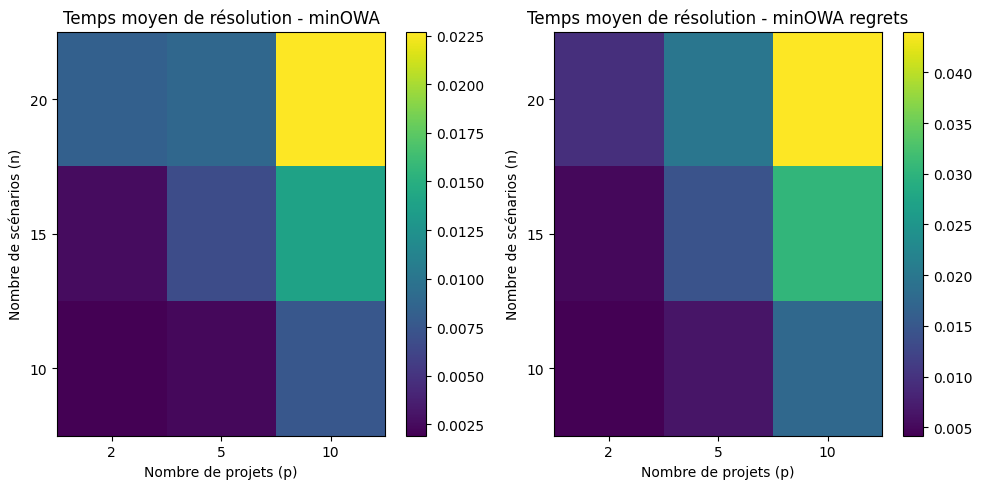

In [ ]:
import time


def average_resolution_time(model_function, instances):
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        model_function(valeurs_scenarios=instance['valeurs'])
        end_time = time.time()
        total_time += (end_time - start_time)
    
    # Calculer le temps moyen pour les 10 instances
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            # Générer 10 instances pour le couple (n, p)
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # Calculer le temps moyen pour le modèle maxmin
            avg_time_maxmin = average_resolution_time(minOWA, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            # Calculer le temps moyen pour le modèle regret
            avg_time_regret = average_resolution_time(minOWAregrets, instances)
            regret_times[i, j] = avg_time_regret
            
            print(f"(n={n}, p={p}) - Temps moyen maxOWA: {avg_time_maxmin:.4f} s, Temps moyen minOWA: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, n_values, p_values

def plot_results(maxmin_times, regret_times, n_values, p_values):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Heatmap pour le modèle maxmin
    im1 = axs[0].imshow(maxmin_times, cmap='viridis', aspect='auto')
    axs[0].set_title("Temps moyen de résolution - minOWA")
    axs[0].set_xlabel("Nombre de projets (p)")
    axs[0].set_ylabel("Nombre de scénarios (n)")
    axs[0].set_xticks(np.arange(len(p_values)))
    axs[0].set_yticks(np.arange(len(n_values)))
    axs[0].set_xticklabels(p_values)
    axs[0].set_yticklabels(n_values)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')
    
    # Heatmap pour le modèle regret
    im2 = axs[1].imshow(regret_times, cmap='viridis', aspect='auto')
    axs[1].set_title("Temps moyen de résolution - minOWA regrets")
    axs[1].set_xlabel("Nombre de projets (p)")
    axs[1].set_ylabel("Nombre de scénarios (n)")
    axs[1].set_xticks(np.arange(len(p_values)))
    axs[1].set_yticks(np.arange(len(n_values)))
    axs[1].set_xticklabels(p_values)
    axs[1].set_yticklabels(n_values)
    fig.colorbar(im2, ax=axs[1], orientation='vertical')
    
    plt.tight_layout()
    plt.savefig("figures/ex3/performance_OWA.svg",bbox_inches='tight')

    plt.show()

n_values = [20, 15, 10]  # Nombre de scénarios
p_values = [2, 5, 10] # Nombre de projets

maxmin_times, regret_times, n_values, p_values = main(n_values, p_values)

plot_results(maxmin_times, regret_times, n_values, p_values)

(n=20, p=2) - Temps moyen maxOWA: 0.0063 s, Temps moyen minOWA: 0.0083 s
(n=20, p=5) - Temps moyen maxOWA: 0.0047 s, Temps moyen minOWA: 0.0173 s
(n=20, p=10) - Temps moyen maxOWA: 0.0081 s, Temps moyen minOWA: 0.0282 s
(n=15, p=2) - Temps moyen maxOWA: 0.0017 s, Temps moyen minOWA: 0.0040 s
(n=15, p=5) - Temps moyen maxOWA: 0.0023 s, Temps moyen minOWA: 0.0092 s
(n=15, p=10) - Temps moyen maxOWA: 0.0045 s, Temps moyen minOWA: 0.0207 s
(n=10, p=2) - Temps moyen maxOWA: 0.0013 s, Temps moyen minOWA: 0.0029 s
(n=10, p=5) - Temps moyen maxOWA: 0.0014 s, Temps moyen minOWA: 0.0049 s
(n=10, p=10) - Temps moyen maxOWA: 0.0016 s, Temps moyen minOWA: 0.0097 s


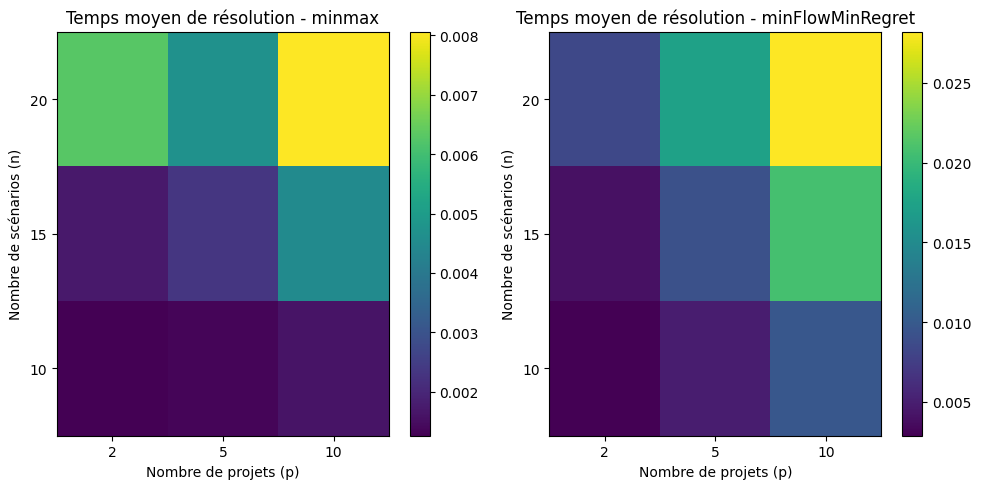

In [ ]:
import time


def average_resolution_time(model_function, instances):
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        model_function(valeurs_scenarios=instance['valeurs'])
        end_time = time.time()
        total_time += (end_time - start_time)
    
    # Calculer le temps moyen pour les 10 instances
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # modèle maxmin
            avg_time_maxmin = average_resolution_time(minFlowMaxMin, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            #modèle regret
            avg_time_regret = average_resolution_time(minFlowMinRegret, instances)
            regret_times[i, j] = avg_time_regret
            
            print(f"(n={n}, p={p}) - Temps moyen maxOWA: {avg_time_maxmin:.4f} s, Temps moyen minOWA: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, n_values, p_values

def plot_results(maxmin_times, regret_times, n_values, p_values):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Heatmap pour le modèle maxmin
    im1 = axs[0].imshow(maxmin_times, cmap='viridis', aspect='auto')
    axs[0].set_title("Temps moyen de résolution - minmax")
    axs[0].set_xlabel("Nombre de projets (p)")
    axs[0].set_ylabel("Nombre de scénarios (n)")
    axs[0].set_xticks(np.arange(len(p_values)))
    axs[0].set_yticks(np.arange(len(n_values)))
    axs[0].set_xticklabels(p_values)
    axs[0].set_yticklabels(n_values)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')
    
    # Heatmap pour le modèle regret
    im2 = axs[1].imshow(regret_times, cmap='viridis', aspect='auto')
    axs[1].set_title("Temps moyen de résolution - minFlowMinRegret")
    axs[1].set_xlabel("Nombre de projets (p)")
    axs[1].set_ylabel("Nombre de scénarios (n)")
    axs[1].set_xticks(np.arange(len(p_values)))
    axs[1].set_yticks(np.arange(len(n_values)))
    axs[1].set_xticklabels(p_values)
    axs[1].set_yticklabels(n_values)
    fig.colorbar(im2, ax=axs[1], orientation='vertical')
    
    plt.tight_layout()
    plt.savefig("figures/ex3/performance_minmax.svg",bbox_inches='tight')

    plt.show()

n_values = [20, 15, 10]  # Nombre de scénarios
p_values = [2, 5, 10] # Nombre de projets

maxmin_times, regret_times, n_values, p_values = main(n_values, p_values)

plot_results(maxmin_times, regret_times, n_values, p_values)

In [ ]:
import time


def average_resolution_time(model_function, instances):
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        model_function(valeurs_scenarios=instance['valeurs'])
        end_time = time.time()
        total_time += (end_time - start_time)
    
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    owa_times = np.zeros((len(n_values), len(p_values)))
    owa_regret_times = np.zeros((len(n_values), len(p_values)))

    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # maxmin
            avg_time_maxmin = average_resolution_time(minFlowMaxMin, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            #  modèle regret
            avg_time_regret = average_resolution_time(minFlowMinRegret, instances)
            regret_times[i, j] = avg_time_regret

            # modèle minowa
            avg_time_owa = average_resolution_time(minOWA, instances)
            owa_times[i, j] = avg_time_owa
            
            # modèle minowaregret
            avg_time_regret_owa = average_resolution_time(minOWAregrets, instances)
            owa_regret_times[i, j] = avg_time_regret_owa
            
            print(f"(n={n}, p={p}) - Temps moyen maxOWA: {avg_time_maxmin:.4f} s, Temps moyen minOWA: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, owa_times, owa_regret_times, n_values, p_values


n_values = [10, 15, 20]  # Nombre de scénarios
p_values = [2, 5, 10] # Nombre de projets

maxmin_times, regret_times,owa_times,owa_regret_times, n_values, p_values = main(n_values, p_values)



(n=10, p=2) - Temps moyen maxOWA: 0.0017 s, Temps moyen minOWA: 0.0044 s
(n=10, p=5) - Temps moyen maxOWA: 0.0016 s, Temps moyen minOWA: 0.0061 s
(n=10, p=10) - Temps moyen maxOWA: 0.0022 s, Temps moyen minOWA: 0.0124 s
(n=15, p=2) - Temps moyen maxOWA: 0.0020 s, Temps moyen minOWA: 0.0041 s
(n=15, p=5) - Temps moyen maxOWA: 0.0025 s, Temps moyen minOWA: 0.0098 s
(n=15, p=10) - Temps moyen maxOWA: 0.0031 s, Temps moyen minOWA: 0.0162 s
(n=20, p=2) - Temps moyen maxOWA: 0.0035 s, Temps moyen minOWA: 0.0078 s
(n=20, p=5) - Temps moyen maxOWA: 0.0048 s, Temps moyen minOWA: 0.0150 s
(n=20, p=10) - Temps moyen maxOWA: 0.0059 s, Temps moyen minOWA: 0.0283 s


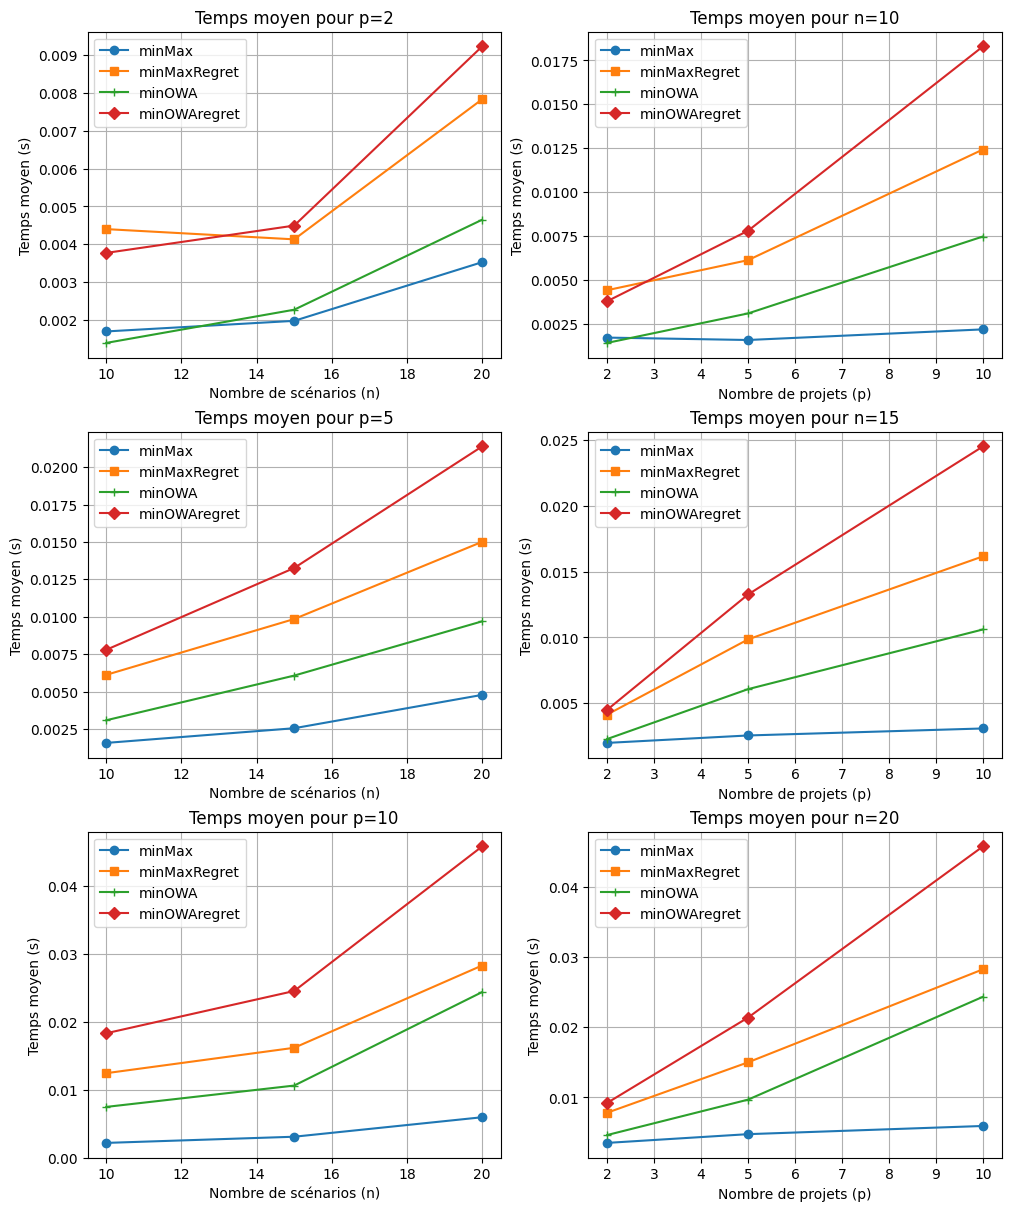

In [ ]:
def plot_results_line_graphs(maxmin_times, regret_times, owa_times, owa_regret_times, n_values, p_values):
    num_graphs = len(p_values) + len(n_values)  # Total des graphes
    fig, axes = plt.subplots(nrows=num_graphs // 2, ncols=2, figsize=(10, 12), constrained_layout=True)
    
    for j, p in enumerate(p_values):
        ax = axes[j, 0]
        ax.plot(n_values, maxmin_times[:, j], label="minMax", marker='o')
        ax.plot(n_values, regret_times[:, j], label="minMaxRegret", marker='s')
        ax.plot(n_values, owa_times[:, j], label="minOWA", marker='+')
        ax.plot(n_values, owa_regret_times[:, j], label="minOWAregret", marker='D')
        ax.set_title(f"Temps moyen pour p={p}")
        ax.set_xlabel("Nombre de scénarios (n)")
        ax.set_ylabel("Temps moyen (s)")
        ax.legend()
        ax.grid(True)
    
    for i, n in enumerate(n_values):
        ax = axes[i, 1]
        ax.plot(p_values, maxmin_times[i, :], label="minMax", marker='o')
        ax.plot(p_values, regret_times[i, :], label="minMaxRegret", marker='s')
        ax.plot(p_values, owa_times[i, :], label="minOWA", marker='+')
        ax.plot(p_values, owa_regret_times[i, :], label="minOWAregret", marker='D')
        ax.set_title(f"Temps moyen pour n={n}")
        ax.set_xlabel("Nombre de projets (p)")
        ax.set_ylabel("Temps moyen (s)")
        ax.legend()
        ax.grid(True)
    
    plt.savefig("figures/ex3/performance_comparison_all.svg", bbox_inches='tight')
    plt.show()

plot_results_line_graphs(maxmin_times, regret_times,owa_times,owa_regret_times, n_values, p_values)